### 개요

코로나 전부터 음악 및 영상 스트리밍 서비스는 지속적으로 성장해왔다.

나는 벅스뮤직, 유투브 뮤직 이 두가지의 음원 스트리밍 어플을 사용하는데 여전히 맞춤형 알고리즘이 그닥 잘 작동하는 것 같지 않다고 느낀다.

지나치게 같은 아티스트의 음악, 그 아티스트가 피처링한 음악만을 추천하고 그 플레이리스트대로 듣다 보면 금새 질리기도 한다.

사용자의 취향을 귀신같이 분석하고, 거기다 새로운 주제를 제시하는 서비스를 만들려면 음악 분류의 정밀함 혹은 세밀함이 선행되어야 한다.

사실 공식적인 음원 발매 외에도 'Soundcloud'같은 곳에 엄청나게 다양한 장르의 음악이 있다. 기존의 장르에 끼워맞추기 힘든 음악도 많다.

이번 프로젝트에서는 음원 스트리밍 서비스 회사의 데이터 분석가로 일한다고 가정했다.

음악 장르를 구분하는 예측 모델을 만들어 새로운 음원 파일을 넣었을 때도 적절히 분류할 수 있도록 할 것이다.

---

'Spotify'에서 제공하는 4만여개의 음원 특성이 담긴 데이터셋을 사용하여, 

1) Random Forest Classification 

2) 신경망 모델

분류 모델이 얼마나 장르를 잘 구분하는지 '정확도'를 통해 평가할 것이다.

본 데이터셋의 label이 될 'genre'는 총 15개인데, 다중 분류모델의 경우 신경망 모델의 성능이 훨씬 좋을 것이라 생각한다. 


1.데이터셋 불러오기 : [원본 데이터](https://www.kaggle.com/mrmorj/dataset-of-songs-in-spotify)를 구들드라이브에 업로드 시킨 후 불러와서 사용함

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

filename = '/content/gdrive/MyDrive/genres_v2.csv'

df = pd.read_csv(filename)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,audio_features,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,audio_features,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,audio_features,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,audio_features,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,audio_features,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [ ]:
#42,305개의 음악의 음원 정보를 담고 있다. 
df.shape

(42305, 22)

2.데이터 탐색 및 전처리

<데이터셋 요소 설명>

**danceability** : 춤추기에 적합한 음악인지 판단. 템포, 리듬 안정성, 비트 강도 등이 전체적으로 일정한지 조합하여 정해진다.

**energy** : 에너지가 클수록 빠르고 크고 시끄러운 음악이다. ex) 헤비메탈은 에너지가 높고, 모차르트의 자장가는 에너지가 낮다.

**key** : 트랙의 전체 예상 키. 예시:0 = C, 1 = C♯ / D ♭, 2 = D. 키가 감지되지 않는 경우는 -1

**loudness** : 값이 클수록 소리(데시벨)가 큰 음악이다.

**mode** : 음원의 음계 정보. 장조(Major)는 1, 단조(Minor)는 2

**speechiness** : 값이 클수록 노래에 말이 많이 나온다. 트랙에 음성이 포함되어 있는지 여부를 측정. 

**acousticness** : 노래가 어쿠스틱한 정도 (어쿠스틱한 소리는 전자음이 섞이지 않은 생악기 소리)

**instrumentalness** : 트랙에 보컬이 *없는지* 여부 예측. 랩도 보컬에 포함된다. 1.0에 가까울수록 트랙에 보컬 콘텐츠가 포함되지 않을 가능성이 큼.

**liveness** : 값이 클수록 (스튜디오 녹음이 아닌) 실황 녹음일 확률이 높다.

**valence** : 밝고 긍정적인 느낌의 정도

**tempo** : 트랙의 전체 예상 템포. 음악의 속도를 나타낸다. 평균 비트 지속 시간을 기준으로 판단함.

**duration_ms** : 밀리초 단위의 트랙 길이.

**time_signature** : 트랙의 전체 예상 박자표. 각 마디별 비트수 지정.

출처 : [Spotify 개발자 사이트](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/)


In [ ]:
#label 정보 확인하기 => genre
print('genre 개수 :', len(df['genre'].unique()))
print(df['genre'].unique())

genre 개수 : 15
['Dark Trap' 'Underground Rap' 'Trap Metal' 'Emo' 'Rap' 'RnB' 'Pop'
 'Hiphop' 'techhouse' 'techno' 'trance' 'psytrance' 'trap' 'dnb'
 'hardstyle']


- 음원 특성 정보로 장르를 구분 및 예측하는 모델을 만드는 것이 목적임으로 음악적 특성에 해당하지 않는 정보는 제거할 것이다.

 -> 'id',	'uri','track_href',	'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'type'

- 'duration_ms'는 노래 길이를 밀리초 단위로 나타낸 값인데, 대부분의 대중 음악장르가 3~5분 남짓인걸 감안하면 genre와 음악 길이 사이의 연관성은 크게 없을 듯 하다.

- 'time_signature'는 클래스가 1,3,4,5 네개 밖에 안되는데, 95% 이상의 음원이 4에 포함된다. 한마디로 4분의 몇 박자인 음악이 대부분이란 소리다. 


In [ ]:
df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'song_name', 'Unnamed: 0', 'title'],
      dtype='object')

In [ ]:
df['duration_ms'].value_counts()

192000    104
240000     87
224000     65
230400     56
211200     56
         ... 
353375      1
236640      1
431201      1
164963      1
458752      1
Name: duration_ms, Length: 26261, dtype: int64

In [ ]:
df['time_signature'].value_counts(normalize=True)

4    0.955608
3    0.028815
5    0.012032
1    0.003546
Name: time_signature, dtype: float64

In [ ]:
#특성들 중 일부 삭제
df = df.drop(['id', 'uri','track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 
              'title', 'type', 'duration_ms', 'time_signature'], axis='columns')
df.shape

(42305, 12)

In [ ]:
# mode : 장조는 1, 단조는 0. 음계가 장조라고 밝기만 한 것도 아니며, 단조라고 어두운 느낌도 아니다. 
# 음악 장르를 나눌 때 '어두운 느낌, 밝은 느낌'으로 구별짓지 않는다. mode는 genre를 예측하는데 크게 기여할 것 같지 않다. 그러므로 삭제하는게 좋겠다.

In [ ]:
df = df.drop(['mode'], axis='columns')
df.head()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,0.831,0.814,2,-7.364,0.4200,0.0598,0.013400,0.0556,0.3890,156.985,Dark Trap
1,0.719,0.493,8,-7.230,0.0794,0.4010,0.000000,0.1180,0.1240,115.080,Dark Trap
2,0.850,0.893,5,-4.783,0.0623,0.0138,0.000004,0.3720,0.0391,218.050,Dark Trap
3,0.476,0.781,0,-4.710,0.1030,0.0237,0.000000,0.1140,0.1750,186.948,Dark Trap
4,0.798,0.624,2,-7.668,0.2930,0.2170,0.000000,0.1660,0.5910,147.988,Dark Trap


In [ ]:
df['genre'].value_counts(normalize=True)

Underground Rap    0.138872
Dark Trap          0.108214
Hiphop             0.071575
trance             0.070890
trap               0.070606
techhouse          0.070323
dnb                0.070110
psytrance          0.069992
techno             0.069874
hardstyle          0.069401
RnB                0.049616
Trap Metal         0.046236
Rap                0.043683
Emo                0.039712
Pop                0.010897
Name: genre, dtype: float64

In [ ]:
#특성들의 통계정보를 확인해보니, 각 수치의 표기 범위가 달라서 모델 돌리기 전에 정규화를 진행해야 할 것 같다.
df.describe()

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000
mean,0.639364,0.762516,5.370240,-6.465442,0.136561,0.096160,0.283048,0.214079,0.357101,147.474056
std,0.156617,0.183823,3.666145,2.941165,0.126168,0.170827,0.370791,0.175576,0.233200,23.844623
min,0.065100,0.000243,0.000000,-33.357000,0.022700,0.000001,0.000000,0.010700,0.018700,57.967000
25%,0.524000,0.632000,1.000000,-8.161000,0.049100,0.001730,0.000000,0.099600,0.161000,129.931000
50%,0.646000,0.803000,6.000000,-6.234000,0.075500,0.016400,0.005940,0.135000,0.322000,144.973000
75%,0.766000,0.923000,9.000000,-4.513000,0.193000,0.107000,0.722000,0.294000,0.522000,161.464000
max,0.988000,1.000000,11.000000,3.148000,0.946000,0.988000,0.989000,0.988000,0.988000,220.290000


In [ ]:
print(df.dtypes)

danceability        float64
energy              float64
key                   int64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object


In [ ]:
# 'key' -> 데이터 타입 float으로 바꾸기
df['key'] = df['key'].astype(float)

In [ ]:
print(df.dtypes)

danceability        float64
energy              float64
key                 float64
loudness            float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
genre                object
dtype: object


In [ ]:
df['genre'].unique()

array(['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB',
       'Pop', 'Hiphop', 'techhouse', 'techno', 'trance', 'psytrance',
       'trap', 'dnb', 'hardstyle'], dtype=object)

In [ ]:
#label인 'genre'를 숫자형으로 변환하기.
df['genre'] = df['genre'].replace(['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB',
       'Pop', 'Hiphop', 'techhouse', 'techno', 'trance', 'psytrance',
       'trap', 'dnb', 'hardstyle'],[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])

In [ ]:
df.sample(10)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
40132,0.455,0.834,1.0,-3.408,0.0329,0.11600,0.000127,0.7050,0.3700,148.043,14
37198,0.461,0.973,7.0,-3.012,0.1380,0.00897,0.725000,0.1120,0.0471,172.034,13
1691,0.570,0.450,6.0,-10.772,0.0676,0.66600,0.059600,0.1580,0.0395,155.081,0
23970,0.776,0.963,1.0,-4.627,0.0450,0.02540,0.870000,0.0808,0.5690,125.006,8
5434,0.883,0.483,11.0,-8.728,0.3290,0.00688,0.000005,0.0929,0.4010,163.998,1
7508,0.905,0.810,7.0,-4.538,0.2110,0.03490,0.000013,0.1240,0.4860,192.882,1
5975,0.803,0.534,11.0,-7.582,0.1860,0.04670,0.000000,0.1340,0.3310,117.930,1
308,0.741,0.479,1.0,-5.899,0.3020,0.05440,0.000000,0.2310,0.0971,162.020,0
32494,0.589,0.964,9.0,-5.994,0.0463,0.00003,0.825000,0.4070,0.4240,148.030,11
4433,0.594,0.741,7.0,-6.229,0.0244,0.07540,0.627000,0.1460,0.1740,200.004,0


In [ ]:
#null값 없음
df.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
genre               0
dtype: int64

특성 분포 시각화

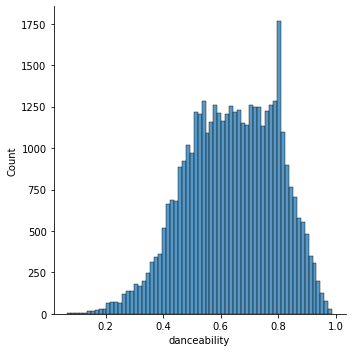

In [ ]:
import seaborn as sns

# danceability 값은 0~1 사이에 위치하며 이상치가 아주 큰 차이의 이상치는 눈에 띄지 않는다.
sns.displot(df, x="danceability")

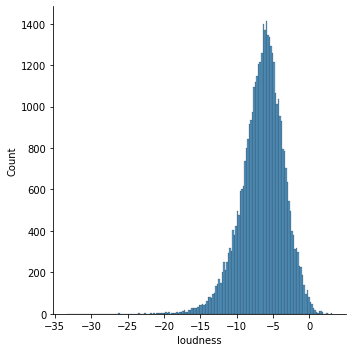

In [ ]:
# -20~0 사이에서 비교적 정규분포의 모습이 나온다. 
sns.displot(df, x="loudness")

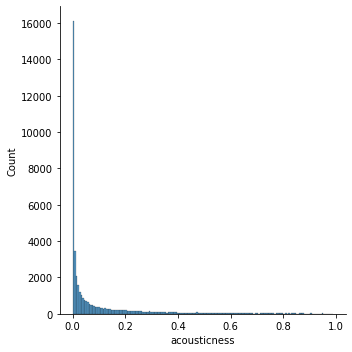

In [ ]:
# 다수가 0.0에 가까운 수치를 가지고 있으나 이상치가 넓게 퍼져있다.
sns.displot(df, x="acousticness")

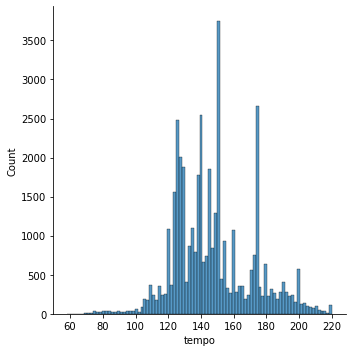

In [ ]:
# 70bpm부터 220bpm까지 넓은 범위로 분포되어있다.
sns.displot(df, x="tempo")

3. train/val 데이터셋 나누기

In [ ]:
target = 'genre'
features = df.columns.drop([target])

X = df[features]
y = df[target]

In [ ]:
#특성 데이터 정규화하기 => MinMaxScaler : 모든 특성값을 0~1사이에 있도록 만든다. 이상치에 민감한 편.
scaler = MinMaxScaler()
X_sc = scaler.fit_transform(X)

In [ ]:
#레이블 데이터도 array로 맞춰 주기
y_arr = y.values
y_arr

array(['Dark Trap', 'Dark Trap', 'Dark Trap', ..., 'hardstyle',
       'hardstyle', 'hardstyle'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

#train/test 나누기
X_train,X_test,y_train,y_test = train_test_split(X_sc, y_arr, test_size=0.2, random_state=20)

In [ ]:
X_train.shape, X_test.shape

((33844, 10), (8461, 10))

In [ ]:
y_train.shape,y_test.shape

((33844,), (8461,))

4. 머신러닝 모델 - RandomForest Classification 활용하기



In [ ]:
import numpy as np
np.random.seed(111)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
#RandomForest 모델 만들기

rfc = RandomForestClassifier(max_depth=7, 
                             max_features=10, #모든 특성 다 넣기
                             n_estimators=150,
                             random_state=50,
                             min_samples_leaf=10,
                             n_jobs=-1
                            )

rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_train)
print('train 데이터 정확도:', accuracy_score(y_train, y_pred))

train 데이터 정확도: 0.6129003663869519


In [ ]:
# label의 분포가 각 클래스별로 불균형하니 StratifiedKFold로 교차검증 수행

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(rfc, X_train, y_train, cv=skf, 
                         scoring='accuracy')

print('train 데이터 교차 검증별 정확도:', np.round(scores, 4))
print('train 데이터 정확도:', np.round(np.mean(scores), 4))

train 데이터 교차 검증별 정확도: [0.6095 0.597  0.5996 0.594  0.604 ]
train 데이터 정확도: 0.6008


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores_t = cross_val_score(rfc, X_test, y_test, cv=skf, 
                         scoring='accuracy')

print('test 데이터 교차 검증별 정확도:', np.round(scores_t, 4))
print('test 데이터 정확도:', np.round(np.mean(scores_t), 4))

test 데이터 교차 검증별 정확도: [0.5954 0.5963 0.578  0.5987 0.5922]
test 데이터 정확도: 0.5921


In [ ]:
# y_test_pred = rfc.predict(X_test)
# print('test 데이터 정확도:', accuracy_score(y_test, y_test_pred))

음원 특성을 기준으로 음악 장르를 구분하는 머신러닝 모델을 만들었다.

StratifiedKFold을 사용해 교차검증을 수행하니 test데이터는 train데이터에 비해 1% 정도 성능이 떨어졌다.

새로운 음원 정보 데이터가 들어왔을 때, 그 음원의 장르를 약 59%의 정확도로 구분한다고 볼 수 있겠다. 성능이 그닥 좋진 않다.

6. 딥러닝 모델 - 다층퍼셉트론

In [ ]:
np.random.seed(111)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#disable the v2 behavior and eager mode
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# model 만들기
def base_model():
  model = Sequential()
  model.add(Dense(150, input_dim=10, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(150, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(150, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(15, activation='softmax'))
  
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

estimator = KerasClassifier(build_fn=base_model,epochs=50, batch_size=128)

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores_nn = cross_val_score(estimator, X_train, y_train, cv=skf, 
                         scoring='accuracy')

print('train 데이터 정확도:', np.round(np.mean(scores_nn), 4))

Train on 27075 samples
Epoch 1/50
27075/27075 [==============================] - 1s 44us/sample - loss: 1.9729 - acc: 0.3228
Epoch 2/50
27075/27075 [==============================] - 1s 32us/sample - loss: 1.6003 - acc: 0.4400
Epoch 3/50
27075/27075 [==============================] - 1s 31us/sample - loss: 1.4816 - acc: 0.4861
Epoch 4/50
27075/27075 [==============================] - 1s 31us/sample - loss: 1.3931 - acc: 0.5153
Epoch 5/50
27075/27075 [==============================] - 1s 31us/sample - loss: 1.3276 - acc: 0.5359
Epoch 6/50
27075/27075 [==============================] - 1s 34us/sample - loss: 1.2876 - acc: 0.5508
Epoch 7/50
27075/27075 [==============================] - 1s 35us/sample - loss: 1.2508 - acc: 0.5637
Epoch 8/50
27075/27075 [==============================] - 1s 33us/sample - loss: 1.2271 - acc: 0.5703
Epoch 9/50
27075/27075 [==============================] - 1s 31us/sample - loss: 1.2064 - acc: 0.5754
Epoch 10/50
27075/27075 [==============================] - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Train on 27075 samples
Epoch 1/50
27075/27075 [==============================] - 1s 34us/sample - loss: 1.9761 - acc: 0.3220
Epoch 2/50
27075/27075 [==============================] - 1s 30us/sample - loss: 1.6023 - acc: 0.4382
Epoch 3/50
27075/27075 [==============================] - 1s 30us/sample - loss: 1.4690 - acc: 0.4882
Epoch 4/50
27075/27075 [==============================] - 1s 33us/sample - loss: 1.3784 - acc: 0.5208
Epoch 5/50
27075/27075 [==============================] - 1s 32us/sample - loss: 1.3113 - acc: 0.5423
Epoch 6/50
27075/27075 [==============================] - 1s 33us/sample - loss: 1.2738 - acc: 0.5536
Epoch 7/50
27075/27075 [==============================] - 1s 33us/sample - loss: 1.2487 - acc: 0.5656
Epoch 8/50
27075/27075 [==============================] - 1s 32us/sample - loss: 1.2213 - acc: 0.5725
Epoch 9/50
27075/27075 [==============================] - 1s 33us/sample - loss: 1.2030 - acc: 0.5755
Epoch 10/50
27075/27075 [==============================] - 

In [ ]:
print('train 데이터 정확도:', np.round(np.mean(scores_nn), 4))

train 데이터 정확도: 0.6393


교차검증으로 estimator 모델을 평가해보니, 신경망 모델로 돌린 train데이터의 정확도는 머신러닝 모델에 비해 거의 4% 정도 증가했다.


In [ ]:
# test데이터에 학습
estimator.fit(X_train,y_train)
y_preds = estimator.predict(X_test)

Train on 33844 samples
Epoch 1/50
33844/33844 [==============================] - 1s 33us/sample - loss: 1.9250 - acc: 0.3310
Epoch 2/50
33844/33844 [==============================] - 1s 31us/sample - loss: 1.5427 - acc: 0.4609
Epoch 3/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.4122 - acc: 0.5090
Epoch 4/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.3242 - acc: 0.5389
Epoch 5/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.2750 - acc: 0.5553
Epoch 6/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.2438 - acc: 0.5680
Epoch 7/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.2178 - acc: 0.5734
Epoch 8/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.1909 - acc: 0.5823
Epoch 9/50
33844/33844 [==============================] - 1s 30us/sample - loss: 1.1746 - acc: 0.5894
Epoch 10/50
33844/33844 [==============================] - 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
print('test 데이터 정확도:', accuracy_score(y_test, y_preds))

test 데이터 정확도: 0.6381042429972816


머신러닝 모델에 비해 test데이터의 정확도가 0.5863->0.6381으로 약 5%정도 성능이 올랐다.

In [ ]:
0.6381 - 0.5863

0.05179999999999996

In [ ]:
results = estimator.fit(X_train,y_train)

Train on 33844 samples
Epoch 1/30
33844/33844 [==============================] - 1s 33us/sample - loss: 1.8511 - acc: 0.3581
Epoch 2/30
33844/33844 [==============================] - 1s 30us/sample - loss: 1.4894 - acc: 0.4849
Epoch 3/30
33844/33844 [==============================] - 1s 31us/sample - loss: 1.3660 - acc: 0.5269
Epoch 4/30
33844/33844 [==============================] - 1s 29us/sample - loss: 1.2972 - acc: 0.5499
Epoch 5/30
33844/33844 [==============================] - 1s 30us/sample - loss: 1.2484 - acc: 0.5651
Epoch 6/30
33844/33844 [==============================] - 1s 31us/sample - loss: 1.2178 - acc: 0.5738
Epoch 7/30
33844/33844 [==============================] - 1s 30us/sample - loss: 1.1937 - acc: 0.5824
Epoch 8/30
33844/33844 [==============================] - 1s 30us/sample - loss: 1.1782 - acc: 0.5870
Epoch 9/30
33844/33844 [==============================] - 1s 30us/sample - loss: 1.1607 - acc: 0.5906
Epoch 10/30
33844/33844 [==============================] - 


train데이터의 학습 모양을 시각화 해보면, accuracy값은 계속 증가하고 loss값은 감소하는 양상을 확인할 수 있다

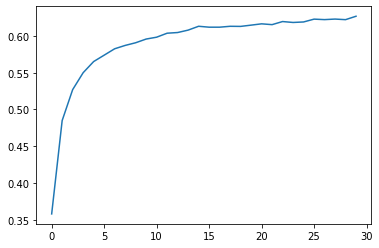

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.history['acc'])

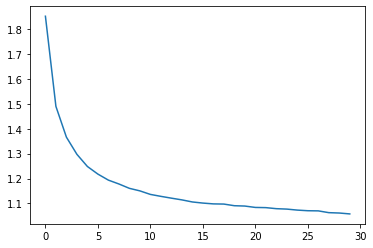

In [ ]:
plt.plot(results.history['loss'])